# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). 

## Project Overview
Sparkify, is our fictious music streaming app, and has data regarding its user's actions on its app. It has two main categories of users - free and paid. Paid users pay a premium monthly for few additional benefits. The project is done as a part of Udacity Data Scientist Nanodegree program - Term 2, final Capstone project. 
We intend to use Spark via python (Pyspark) on this project and use its many features. We will initially do some exploratory analysis followed by Feature engineering and Machine learning to solve our actual problem at hand. We will use Spark ML library for this.
## Problem Statement
The project aims to detect users who are more likely to churn the platform all together based on the past users actions.
## Metrics
We will be using F1 score as a metric to optimize our model as we have relatively very small number of positives. AUC ROC could have been used in cases where we have a good number of positives as it relies on True positive, and False positive counts.

## Let's get Started

In [108]:
#import required libraries
import dill

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import avg, col, concat, isnull, desc, explode, lit, min, max, split, udf, count, round, when, lag, dense_rank, ceil, floor
from pyspark.sql.types import IntegerType, StructType, StringType, DoubleType, StructField
from pyspark.sql.window import Window

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier,LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, StandardScaler, VectorAssembler, StringIndexer, IndexToString
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [ ]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [ ]:
df = spark.read.json('mini_sparkify_event_data.json')
df.persist()

In [9]:
df.count()

286500

In [10]:
df = df.dropDuplicates()
df.count()

286500

In [11]:
#check for missing or Null userIds
print(df[df.userId.isNotNull()].count())
print(df[df.userId==""].count())

286500
8346


In [12]:
print(df[df.sessionId.isNotNull()].count())
print(df[df.sessionId==""].count())

286500
0


In [ ]:
#remove blank userIds which are probably users who did not register
df = df[df.userId!=""]
df.count() #check for size

# Exploratory Data Analysis

Let's get top 20 artists songs played count between the free vs paid users

In [89]:
#get overall top 10 artists and their counts
top_artists = df.filter(df.page=="NextSong").groupby("artist") \
                    .agg(count("artist").alias("total_count")).sort(col("total_count").desc())
top_artists.show(10)

+--------------------+-----------+
|              artist|total_count|
+--------------------+-----------+
|       Kings Of Leon|       1841|
|            Coldplay|       1813|
|Florence + The Ma...|       1236|
|       Dwight Yoakam|       1135|
|            BjÃÂ¶rk|       1133|
|      The Black Keys|       1125|
|                Muse|       1090|
|       Justin Bieber|       1044|
|        Jack Johnson|       1007|
|              Eminem|        953|
+--------------------+-----------+
only showing top 10 rows



In [90]:
#limit top artists to top 10 artists
top_artists_pd = top_artists.toPandas()
top_artists_pd = top_artists_pd.head(10)

Similarly pull top artists, their song counts of free users, and top artists, their song counts of paid users.

In [91]:
#get free users top 10 artists and their counts
free_top_artists = df.filter((df.page=="NextSong") & (df.level=="free")).groupby("artist") \
                        .agg(count("artist").alias("total_count")).sort(col("total_count").desc())

free_top_artists_pd = free_top_artists.toPandas()
free_top_artists_pd = free_top_artists_pd.head(10)
free_top_artists_pd

,artist,total_count
0,Kings Of Leon,357
1,Coldplay,319
2,Florence + The Machine,262
3,Dwight Yoakam,236
4,The Black Keys,226
5,BjÃÂ¶rk,201
6,Muse,192
7,Justin Bieber,182
8,Radiohead,181
9,Eminem,173


In [92]:
#get paid users top 10 artists and their counts
paid_top_artists = df.filter((df.page=="NextSong") & (df.level=="paid")) \
                    .groupby("artist").agg(count("artist").alias("total_count")).sort(col("total_count").desc())

paid_top_artists_pd = paid_top_artists.toPandas()
paid_top_artists_pd = paid_top_artists_pd.head(10)
paid_top_artists_pd

,artist,total_count
0,Coldplay,1494
1,Kings Of Leon,1484
2,Florence + The Machine,974
3,BjÃÂ¶rk,932
4,The Black Keys,899
5,Dwight Yoakam,899
6,Muse,898
7,Justin Bieber,862
8,Jack Johnson,835
9,Eminem,780


Let's plot the above to see the artists remained the same across and how the views changed between levels.

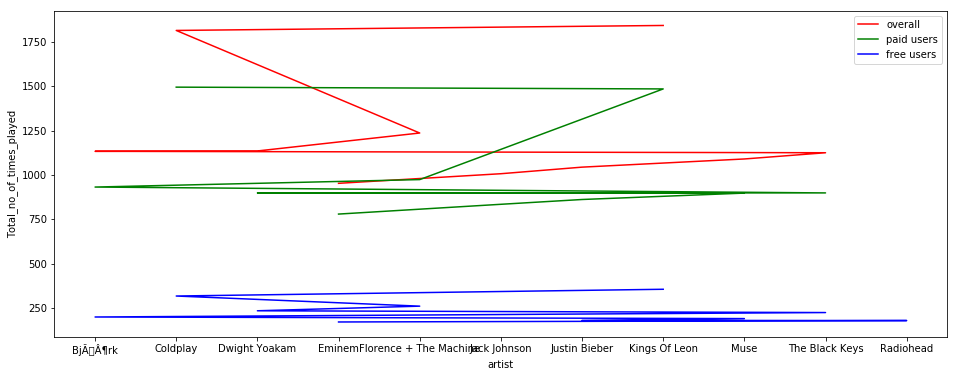

In [126]:
plt.figure(figsize=(16,6))
plt.plot(top_artists_pd["artist"], top_artists_pd["total_count"],'r')
plt.plot(paid_top_artists_pd["artist"], paid_top_artists_pd["total_count"],'g')
plt.plot(free_top_artists_pd["artist"], free_top_artists_pd["total_count"],'b')
plt.legend(labels=["overall","paid users","free users"])
plt.xlabel("artist")
plt.ylabel("Total_no_of_times_played");

We see that there is no major change in the listening preferences between the free and paid users. In general, the number of times songs are listened by paid users is much higher than the free users implying higher engagement of the paid users with Sparkify.

## Identifying users who've Churned/Downgraded

In [19]:
#different Pages available in Sparkify
df.select("page").dropDuplicates().sort("page").show(50)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



* The events causing the Churn is **Cancellation Conf..** 
* Similarly, event causing the downgrade is **Submit Downgrade**

In [93]:
#create udf to check if action page is churn related
churn_event = udf(lambda x: 1 if x =="Cancellation Confirmation" else 0, IntegerType())

In [94]:
#create column to identify churn users 
churn_users = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_users_list = [(row['userId']) for row in churn_users.collect()]
df = df.withColumn("churn", df.userId.isin(churn_users_list))

In [95]:
#create udf to check if action page is downgrade related
downgrade_event = udf(lambda x: 1 if x =="Submit Downgrade" else 0, IntegerType())

In [96]:
#create column to identify downgrade users
downgrade_users = df.filter(df.page=="Submit Downgrade").select("userId").dropDuplicates()
downgrade_users_list = [(row['userId']) for row in downgrade_users.collect()]
df = df.withColumn("downgrade", df.userId.isin(downgrade_users_list))

In [14]:
#sanity check
df.where(df.page=="Submit Downgrade").take(5)

[Row(artist=None, auth='Logged In', firstName='Kael', gender='M', itemInSession=47, lastName='Baker', length=None, level='paid', location='Kingsport-Bristol-Bristol, TN-VA', method='PUT', page='Submit Downgrade', registration=1533102330000, sessionId=249, song=None, status=307, ts=1538393619000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', userId='131', churn=False, downgrade=True),
 Row(artist=None, auth='Logged In', firstName='Calvin', gender='M', itemInSession=17, lastName='Marshall', length=None, level='paid', location='Pittsburgh, PA', method='PUT', page='Submit Downgrade', registration=1537120757000, sessionId=313, song=None, status=307, ts=1538516445000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2"', userId='38', churn=False, downgrade=True),
 Row(artist=None, auth='Logged In', firstName='Kaylenn', gender='F

In [25]:
#count of churned users by gender
df.dropDuplicates(['gender','userid']).groupby('gender','churn').count().sort('churn').show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     F|false|   84|
|     M|false|   89|
|     M| true|   32|
|     F| true|   20|
+------+-----+-----+



### Compare churned users behaviour with non-churn users

#### Compare Song counts for different week days

In [97]:
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
df = df.withColumn("weekday", get_weekday(df.ts))

In [98]:
#create Churn and non_churn Pandas df for plots
df_churn = df.where('churn=1')
df_nonchurn = df.where('churn=0')

In [99]:
#get song counts for churn and non_churn users by day
df_weekday_pd = df['gender','page','userid','churn','weekday'].filter(df.page == 'NextSong') \
                            .groupby('churn', 'weekday').count().orderBy(df['weekday'].cast('float')).toPandas()
df_weekday_churn_pd = df_weekday_pd[df_weekday_pd['churn']==1]
df_weekday_nonchurn_pd = df_weekday_pd[df_weekday_pd['churn']==0]

In [29]:
df_weekday_pd.head(20)

,churn,weekday,count
0,True,0,2004
1,False,0,15366
2,False,1,29767
3,True,1,5606
4,False,2,32633
5,True,2,6197
6,True,3,5969
7,False,3,31706
8,False,4,30037
9,True,4,6263


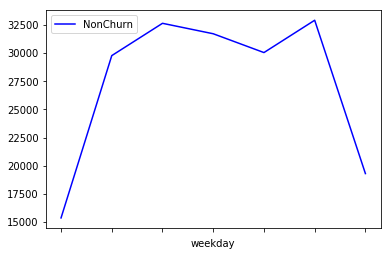

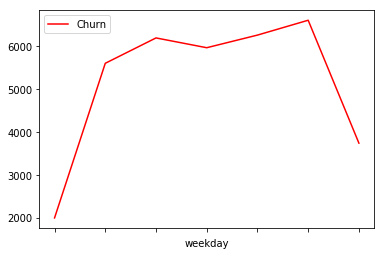

In [30]:
df_weekday_nonchurn_pd.plot(x="weekday",y="count",color='Blue',label='NonChurn')
df_weekday_churn_pd.plot(x="weekday",y="count",color='Red', label='Churn');

Both Churna and Non-Churn users generally have a consistent listening counts with highs during weekdays.

# Feature Engineering

In order to build our model, let's engineer a few features which we think may play a significant factor in deciding whether a user may churn or not.

**Feature 1:** Average number of songs listened by a user in each session
* Hypothesis: If a user is there for longer duration in each session he/she will see more value and benefits of Sparkify and is less likely to churn *

In [100]:
user_session_songcount = df.select('userId','page','sessionId').filter(df.page == 'NextSong') \
                            .groupby('userId','sessionId').count()
feature1_songs_session = user_session_songcount.groupby("userId").agg(round(avg('count'),2) \
                                                                        .alias('songs_per_session'))

In [101]:
feature1_songs_session.show(5)

+------+-----------------+
|userId|songs_per_session|
+------+-----------------+
|100010|            39.29|
|200002|             64.5|
|   125|              8.0|
|    51|            211.1|
|   124|           145.68|
+------+-----------------+
only showing top 5 rows



**Feature 2:** Total number of sessions of a user
* Hypothesis: If the user is less frequent on the platform, he/she will probably churn *

In [102]:
feature2_session_count = df.select('userId','sessionId').dropDuplicates().groupby('userId').count() \
                                    .withColumnRenamed('count','session_count')
feature2_session_count.show(5)

+------+-------------+
|userId|session_count|
+------+-------------+
|100010|            7|
|200002|            6|
|   125|            1|
|    51|           10|
|   124|           29|
+------+-------------+
only showing top 5 rows



**Feature 3:** Average number of different Pages visited in each session

In [103]:
user_session_pagecount = df.select('userId','page','sessionId').dropDuplicates() \
                                .groupby('userId','sessionId').count()
feature3_page_session = user_session_pagecount.groupby("userId") \
                                                .agg(round(avg('count'),2).alias('pages_per_session'))

In [104]:
feature3_page_session.show(5)

+------+-----------------+
|userId|pages_per_session|
+------+-----------------+
|100010|             6.71|
|200002|              7.5|
|   125|              4.0|
|    51|              8.5|
|   124|             7.38|
+------+-----------------+
only showing top 5 rows



**Feature 4:** Gender of user

* It is important to check if Sparkify has any gender related affinity from any particular gender. 
* We will encode the Gender values into 1s and 0s

In [105]:
feature4_gender = df.select('userId','gender').dropDuplicates() \
                    .replace(['M','F'],['1','0'],'gender')
feature4_gender = feature4_gender.select("userId", feature4_gender.gender.cast("int"))
feature4_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
|    72|     0|
|300023|     0|
+------+------+
only showing top 5 rows



**Feature 5:** Current User level - Paid or free
* Hypothesis: User is likely to stay longer if the user is a paid user

In [106]:
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, churn: boolean, downgrade: boolean, weekday: string]

In [107]:
user_last_time = df.groupby('userId').agg(max('ts').alias('ts'))
feature5_level = user_last_time.join(df,on=['userId','ts'],how='left').select('userId','level').dropDuplicates() \
                                    .replace(['paid','free'],['1','0'],'level')
feature5_level = feature5_level.select("userId", feature5_level.level.cast("int"))
feature5_level.show(5)

+------+-----+
|userId|level|
+------+-----+
|100021|    0|
|200001|    0|
|300022|    1|
|   112|    0|
|200007|    1|
+------+-----+
only showing top 5 rows



**Feature 6:** Average session time for a user
* Hypothesis: More the average session time for a user, he'she is less likely to churn from the platform.

In [108]:
avg_session = df.groupby('userId','sessionId').agg(round(((max('ts')-min('ts'))/(1000*60)),2) \
                                                    .alias('session_time')).dropDuplicates()
feature6_avg_session_time = avg_session.groupby('userId').agg(round(avg('session_time'),2).alias('avg_session_time'))
feature6_avg_session_time.show(5)                                                    

+------+----------------+
|userId|avg_session_time|
+------+----------------+
|100010|          154.48|
|200002|           266.4|
|   125|           29.57|
|    51|          872.36|
|   124|          578.99|
+------+----------------+
only showing top 5 rows



**Feature 7:** Number of times user visited different pages in total
* Hypothesis: The way user browses different pages on Sparkify may give us some insight into which users will churn depending on the different pages he chooses to access.

In [109]:
#check all page names available
df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



We will create features only for those Pages which are generic and **NOT** one time in nature, like Downgrade, or Cancellation.

In [110]:
feature7_thumbs_down = df.where(df.page=='Thumbs Down').groupby('userId').count() \
                            .withColumnRenamed('count','thumbs_down_count')
feature7_thumbs_down.show(5)

+------+-----------------+
|userId|thumbs_down_count|
+------+-----------------+
|100010|                5|
|200002|                6|
|    51|               21|
|   124|               41|
|     7|                1|
+------+-----------------+
only showing top 5 rows



In [111]:
feature7_thumbs_up = df.where(df.page=='Thumbs Up').groupby('userId').count() \
                            .withColumnRenamed('count','thumbs_up_count')
feature7_home = df.where(df.page=='Home').groupby('userId').count() \
                            .withColumnRenamed('count','home_count')
feature7_roll_advert = df.where(df.page=='Roll Advert').groupby('userId').count() \
                            .withColumnRenamed('count','roll_advert_count')
feature7_logout = df.where(df.page=='Logout').groupby('userId').count() \
                            .withColumnRenamed('count','logout_count')
feature7_save_settings = df.where(df.page=='Save Settings').groupby('userId').count() \
                            .withColumnRenamed('count','save_settings_count')
feature7_settings = df.where(df.page=='Settings').groupby('userId').count() \
                            .withColumnRenamed('count','settings_count')
feature7_about = df.where(df.page=='About').groupby('userId').count() \
                            .withColumnRenamed('count','about_count')
feature7_add_to_playlist = df.where(df.page=='Add to Playlist').groupby('userId').count() \
                            .withColumnRenamed('count','add_to_playlist_count')
feature7_add_friend = df.where(df.page=='Add Friend').groupby('userId').count() \
                            .withColumnRenamed('count','add_friend_count')
feature7_nextsong = df.where(df.page=='NextSong').groupby('userId').count() \
                            .withColumnRenamed('count','nextsong_count')
feature7_help = df.where(df.page=='Help').groupby('userId').count() \
                            .withColumnRenamed('count','help_count')
feature7_error = df.where(df.page=='Error').groupby('userId').count() \
                            .withColumnRenamed('count','error_count')

**Feature 8:** If a user has downgraded
* Hypothesis: A downgraded user is more likely to churn.

In [124]:
feature8_downgrade = df.select('userId','downgrade').dropDuplicates() \
                        .withColumn('downgraded',when(df.downgrade == True, 1).otherwise(0)) \
                        .select('userId','downgraded')
feature8_downgrade.show(5)

+------+----------+
|userId|downgraded|
+------+----------+
|    73|         0|
|    19|         0|
|200007|         0|
|    25|         1|
|    50|         0|
+------+----------+
only showing top 5 rows



As we cannot replace Boolean values with 1s and 0s, we have created a new column for our feature based on Downgrade column.

**Feature 9:** Average time between sessions
* Hypothesis: More the average time between sessions, higher the chances of churn.

In [207]:
my_window = Window.partitionBy('userId').orderBy('userId','sessionId')

In [208]:
session_min_ts = df.groupby('userId','sessionId').agg(min('ts').alias('session_min_ts'))
session_min_ts.show(5)


+------+---------+--------------+
|userId|sessionId|session_min_ts|
+------+---------+--------------+
|    92|      358| 1538585349000|
|    42|      433| 1538683105000|
|   101|      635| 1539065365000|
|   120|      627| 1539180886000|
|   140|      798| 1539424555000|
+------+---------+--------------+
only showing top 5 rows



In [213]:
p_ses_info = session_min_ts.withColumn("prev_session_min_ts", lag('session_min_ts').over(my_window))
p_ses_info = p_ses_info.dropna()
p_ses_info.show(5)

+------+---------+--------------+-------------------+
|userId|sessionId|session_min_ts|prev_session_min_ts|
+------+---------+--------------+-------------------+
|100010|       78| 1539603322000|      1539003534000|
|100010|      113| 1539699018000|      1539603322000|
|100010|      118| 1540045112000|      1539699018000|
|100010|      133| 1541411290000|      1540045112000|
|100010|      174| 1541731560000|      1541411290000|
+------+---------+--------------+-------------------+
only showing top 5 rows



In [259]:
time_between_sessions = p_ses_info.withColumn("time_bw_ses", round((p_ses_info.session_min_ts - p_ses_info.prev_session_min_ts)/(1000*60*60),2))
feature9_time_between_sessions = time_between_sessions.groupby('userId').agg(round(avg('time_bw_ses'),2).alias('avg_time_bw_ses'))
feature9_time_between_sessions.show(5)

+------+---------------+
|userId|avg_time_bw_ses|
+------+---------------+
|100010|          176.6|
|200002|         216.73|
|   124|          51.43|
|    51|          40.89|
|     7|         203.13|
+------+---------------+
only showing top 5 rows



**Feature 10:** Ratio of average time between sessions during later stages vs initial stages
* Hypothesis: Building on previous point, while average gives a good idea of the frequency of a user coming to Sparkify, it will not tell us if the user has recently started to become frequent or less frequent. This may give us some insight if the user is going to churn.

In [281]:
#create session ranks for each user
time_between_sessions_ranks = time_between_sessions.withColumn("session_rank",dense_rank().over(my_window))
time_between_sessions_ranks.show(10)

+------+---------+--------------+-------------------+-----------+------------+
|userId|sessionId|session_min_ts|prev_session_min_ts|time_bw_ses|session_rank|
+------+---------+--------------+-------------------+-----------+------------+
|100010|       78| 1539603322000|      1539003534000|     166.61|           1|
|100010|      113| 1539699018000|      1539603322000|      26.58|           2|
|100010|      118| 1540045112000|      1539699018000|      96.14|           3|
|100010|      133| 1541411290000|      1540045112000|     379.49|           4|
|100010|      174| 1541731560000|      1541411290000|      88.96|           5|
|100010|      187| 1542818132000|      1541731560000|     301.83|           6|
|200002|       44| 1538501988000|      1538393430000|      30.16|           1|
|200002|      114| 1539708704000|      1538501988000|      335.2|           2|
|200002|      163| 1539847677000|      1539708704000|       38.6|           3|
|200002|      174| 1540235331000|      1539847677000

In [282]:
#create mid rank value column
user_mid_rank = time_between_sessions_ranks.groupby('userId').agg((ceil(max('session_rank')/2)).alias('mid_rank'))
time_between_sessions_ranks = time_between_sessions_ranks.join(user_mid_rank,on='userId',how='left')
time_between_sessions_ranks.show(10)

+------+---------+--------------+-------------------+-----------+------------+--------+
|userId|sessionId|session_min_ts|prev_session_min_ts|time_bw_ses|session_rank|mid_rank|
+------+---------+--------------+-------------------+-----------+------------+--------+
|100010|       78| 1539603322000|      1539003534000|     166.61|           1|       3|
|100010|      113| 1539699018000|      1539603322000|      26.58|           2|       3|
|100010|      118| 1540045112000|      1539699018000|      96.14|           3|       3|
|100010|      133| 1541411290000|      1540045112000|     379.49|           4|       3|
|100010|      174| 1541731560000|      1541411290000|      88.96|           5|       3|
|100010|      187| 1542818132000|      1541731560000|     301.83|           6|       3|
|200002|       44| 1538501988000|      1538393430000|      30.16|           1|       3|
|200002|      114| 1539708704000|      1538501988000|      335.2|           2|       3|
|200002|      163| 1539847677000

In [274]:
#add stage column to indicate if the session is initial or recent
time_between_sessions_stage = time_between_sessions_ranks.withColumn("stage",when(time_between_sessions_ranks.session_rank <= time_between_sessions_ranks.mid_rank,'initial') \
                                                    .otherwise('recent'))
time_between_sessions_stage.show(10)


+------+---------+--------------+-------------------+-----------+------------+--------+-------+
|userId|sessionId|session_min_ts|prev_session_min_ts|time_bw_ses|session_rank|mid_rank|  stage|
+------+---------+--------------+-------------------+-----------+------------+--------+-------+
|100010|       78| 1539603322000|      1539003534000|     166.61|           1|       3|initial|
|100010|      113| 1539699018000|      1539603322000|      26.58|           2|       3|initial|
|100010|      118| 1540045112000|      1539699018000|      96.14|           3|       3|initial|
|100010|      133| 1541411290000|      1540045112000|     379.49|           4|       3| recent|
|100010|      174| 1541731560000|      1541411290000|      88.96|           5|       3| recent|
|100010|      187| 1542818132000|      1541731560000|     301.83|           6|       3| recent|
|200002|       44| 1538501988000|      1538393430000|      30.16|           1|       3|initial|
|200002|      114| 1539708704000|      1

In [284]:
#create averages between sessions for initial stage and recent stages
time_between_sessions_initial_avg = time_between_sessions_stage.where(time_between_sessions_stage.stage=='initial') \
                                                        .groupby('userId').agg(avg('time_bw_ses').alias('initial_avg'))
time_between_sessions_recent_avg = time_between_sessions_stage.where(time_between_sessions_stage.stage=='recent') \
                                                        .groupby('userId').agg(avg('time_bw_ses').alias('recent_avg'))

#join both dataframes created above
time_between_sessions_all = time_between_sessions_initial_avg.join(time_between_sessions_recent_avg,on='userId',how='left')


In [303]:
#create feature as needed
time_between_sessions_all = time_between_sessions_all.withColumn('ratio_recent_to_initial_freq',round(time_between_sessions_all.recent_avg/time_between_sessions_all.initial_avg,2))

feature10_ratio_recent_to_initial_freq = time_between_sessions_all.select('userId','ratio_recent_to_initial_freq')


In [304]:
feature10_ratio_recent_to_initial_freq.show(10)

+------+----------------------------+
|userId|ratio_recent_to_initial_freq|
+------+----------------------------+
|100010|                        2.66|
|200002|                        2.52|
|   124|                        0.87|
|    51|                        0.68|
|     7|                        1.47|
|    15|                        1.77|
|    54|                        0.88|
|   155|                        1.45|
|100014|                        4.62|
|   132|                        0.52|
+------+----------------------------+
only showing top 10 rows



**Final Output Label: Churn**

In [305]:
df_final = df.select('userId','churn').dropDuplicates() \
                        .withColumn('churned',when(df.churn == True, '1').otherwise('0')).select('userId','churned')
df_final = df_final.select("userId", df_final.churned.cast("int"))
df_final.show(5)

+------+-------+
|userId|churned|
+------+-------+
|    19|      0|
|100005|      1|
|200007|      0|
|300007|      1|
|    50|      0|
+------+-------+
only showing top 5 rows



**Merge all features and final outcome label into one dataframe**

In [306]:
#combine all features into one list
features = []
features.append(feature1_songs_session)
features.append(feature2_session_count)
features.append(feature3_page_session)
features.append(feature4_gender)
features.append(feature5_level)
features.append(feature6_avg_session_time)
features.append(feature7_thumbs_down)
features.append(feature7_thumbs_up)
features.append(feature7_home)
features.append(feature7_roll_advert)
features.append(feature7_logout)
features.append(feature7_save_settings)
features.append(feature7_settings)
features.append(feature7_about)
features.append(feature7_add_to_playlist)
features.append(feature7_add_friend)
features.append(feature7_nextsong)
features.append(feature7_help)
features.append(feature7_error)
features.append(feature8_downgrade)
features.append(feature9_time_between_sessions)
features.append(feature10_ratio_recent_to_initial_freq)
features

[DataFrame[userId: string, songs_per_session: double],
 DataFrame[userId: string, session_count: bigint],
 DataFrame[userId: string, pages_per_session: double],
 DataFrame[userId: string, gender: int],
 DataFrame[userId: string, level: int],
 DataFrame[userId: string, avg_session_time: double],
 DataFrame[userId: string, thumbs_down_count: bigint],
 DataFrame[userId: string, thumbs_up_count: bigint],
 DataFrame[userId: string, home_count: bigint],
 DataFrame[userId: string, roll_advert_count: bigint],
 DataFrame[userId: string, logout_count: bigint],
 DataFrame[userId: string, save_settings_count: bigint],
 DataFrame[userId: string, settings_count: bigint],
 DataFrame[userId: string, about_count: bigint],
 DataFrame[userId: string, add_to_playlist_count: bigint],
 DataFrame[userId: string, add_friend_count: bigint],
 DataFrame[userId: string, nextsong_count: bigint],
 DataFrame[userId: string, help_count: bigint],
 DataFrame[userId: string, error_count: bigint],
 DataFrame[userId: stri

In [294]:
def merge_dfs(df1,df2, common_column):
    '''Merges two dfs 
    Input - Two Pyspark dataframes with a common column
    Output - A merged Pyspark dataframe
    '''
    return df1.join(df2, common_column,how='left')

In [307]:
for feature in features:
    df_final = merge_dfs(df_final,feature,'userId')

In [308]:
df_final.show(5)

+------+-------+-----------------+-------------+-----------------+------+-----+----------------+-----------------+---------------+----------+-----------------+------------+-------------------+--------------+-----------+---------------------+----------------+--------------+----------+-----------+----------+---------------+----------------------------+
|userId|churned|songs_per_session|session_count|pages_per_session|gender|level|avg_session_time|thumbs_down_count|thumbs_up_count|home_count|roll_advert_count|logout_count|save_settings_count|settings_count|about_count|add_to_playlist_count|add_friend_count|nextsong_count|help_count|error_count|downgraded|avg_time_bw_ses|ratio_recent_to_initial_freq|
+------+-------+-----------------+-------------+-----------------+------+-----+----------------+-----------------+---------------+----------+-----------------+------------+-------------------+--------------+-----------+---------------------+----------------+--------------+----------+----------

Let's remove all the duplicate rows, and also fill in all the NaN values with 0s. If you are wondering why we have NaNs, it's most likely because of features which may not be there for every user like the number of times every user visited each page.

In [309]:
df_final.persist()

DataFrame[userId: string, churned: int, songs_per_session: double, session_count: bigint, pages_per_session: double, gender: int, level: int, avg_session_time: double, thumbs_down_count: bigint, thumbs_up_count: bigint, home_count: bigint, roll_advert_count: bigint, logout_count: bigint, save_settings_count: bigint, settings_count: bigint, about_count: bigint, add_to_playlist_count: bigint, add_friend_count: bigint, nextsong_count: bigint, help_count: bigint, error_count: bigint, downgraded: int, avg_time_bw_ses: double, ratio_recent_to_initial_freq: double]

In [310]:
df_final.select('userId').count() #size check

225

In [312]:
#replace NaNs in dataframe with 0s
df_final = df_final.na.fill(0)

Save our dataframe as CSV for reading it easily later. Note that this is possible here only because of the small size of our dataset.

In [313]:
#save final df as a csv for future ready access
df_final.write.save('df_final.csv', format="csv", header=True, mode='overwrite')

In [11]:
#specify schema for using while reading the csv into a dataframe
schema = StructType([
    StructField("userId", StringType()),
    StructField("churned", IntegerType()),
    StructField("songs_per_session", DoubleType()),
    StructField("session_count", IntegerType()),
    StructField("pages_per_session", DoubleType()),
    StructField("gender", IntegerType()),
    StructField("level", IntegerType()),
    StructField("avg_session_time", DoubleType()),
    StructField("thumbs_down_count", IntegerType()),
    StructField("thumbs_up_count", IntegerType()),
    StructField("home_count", IntegerType()),
    StructField("roll_advert_count", IntegerType()),
    StructField("logout_count", IntegerType()),
    StructField("save_settings_count", IntegerType()),
    StructField("settings_count", IntegerType()),
    StructField("about_count", IntegerType()),
    StructField("add_to_playlist_count", IntegerType()),
    StructField("add_friend_count", IntegerType()),
    StructField("nextsong_count", IntegerType()),
    StructField("help_count", IntegerType()),
    StructField("error_count", IntegerType()),
    StructField("downgraded", IntegerType()),
    StructField("avg_time_bw_ses", DoubleType()),
    StructField("ratio_recent_to_initial_freq", DoubleType())
                ])

In [12]:
#read_final_df csv as spark df
df_final = spark.read.csv('df_final.csv', header=True, schema=schema)
df_final.persist()

DataFrame[userId: string, churned: int, songs_per_session: double, session_count: int, pages_per_session: double, gender: int, level: int, avg_session_time: double, thumbs_down_count: int, thumbs_up_count: int, home_count: int, roll_advert_count: int, logout_count: int, save_settings_count: int, settings_count: int, about_count: int, add_to_playlist_count: int, add_friend_count: int, nextsong_count: int, help_count: int, error_count: int, downgraded: int, avg_time_bw_ses: double, ratio_recent_to_initial_freq: double]

In [5]:
df_final.count() #size check

225

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Step 1. Train Test Split

In [13]:
features = df_final.drop('userId','churned').columns

In [14]:
train, test = df_final.randomSplit([0.8, 0.2],seed=42)

In [15]:
#Vectorize the features and use Standard scaler to Scale all the features
VectorAssembler = VectorAssembler(inputCols= features, outputCol= "feature_vector")
StandardScaler = StandardScaler(inputCol= "feature_vector", outputCol= "features")
indexer = StringIndexer(inputCol="churned", outputCol="label")

## Logistic Regression Model

In [18]:
#create Logistic Regression model
lr =  LogisticRegression()
pipeline_lr = Pipeline(stages=[VectorAssembler, StandardScaler, indexer, lr])

In [32]:
model_p_lr = pipeline_lr.fit(train)
model_p_lr.save('model_p_lr')

In [33]:
results_p_lr = model_p_lr.transform(test)

In [25]:
def evaluate_model(results):
    """Given a results dataframe returns accuracy and f1-score
    Input - Result dataframe with actual output value in column "label" and predicted value in "prediction"
    Output - Accuracy, Precision, Recall and F1 Score for the model
    """
    
    tp = results.filter("label = 1 and prediction = 1").count()
    tn = results.filter("label = 0 and prediction = 0").count()
    
    fp = results.filter("label = 0 and prediction = 1").count()
    fn = results.filter("label = 1 and prediction = 0").count()
        
    accuracy = (1.0*tp + tn) / (tp+tn+fp+fn)
    precision = 1.0*tp / (tp + fp)
    recall = 1.0*tp / (tp + fn)
    try: 
        f1 = 2.0 * (precision * recall) / (precision + recall) 
    except ZeroDivisionError:
        f1 = 0
    
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F1-Score: ', f1)
    return

In [35]:
evaluate_model(results_p_lr)

Accuracy:  0.7692307692307693
Precision:  0.5454545454545454
Recall:  0.46153846153846156
F1-Score:  0.4999999999999999


We see that without any Hyperparameter tuning or cross validation we have an F1 score of 0.5 for logistic Regression.
Let's try the same with Hyperparameter tuning and cross validation

In [21]:
paramGrid = (ParamGridBuilder() \
             .addGrid(lr.regParam, [0.0, 0.01, 0.1]) \
             .addGrid(lr.elasticNetParam, [0.0, 0.1]) \
             .addGrid(lr.fitIntercept, [True,False]) \
             .addGrid(lr.maxIter, [10, 20, 50, 100])
             .build())

crossval = CrossValidator(estimator=pipeline_lr, \
                          estimatorParamMaps=paramGrid, \
                          evaluator=MulticlassClassificationEvaluator(), \
                          numFolds=3)

In [ ]:
model_lr = crossval.fit(train)
model_lr_best = model_lr.bestModel

In [23]:
model_lr_best.save('model_lr_best')

In [26]:
results_lr = model_lr_best.transform(test)
evaluate_model(results_lr)

Accuracy:  0.7884615384615384
Precision:  0.625
Recall:  0.38461538461538464
F1-Score:  0.4761904761904762


Let's checkout the **best LR model's Coefficients and intercept**, if any.

In [27]:
model_lr_best.stages[-1].coefficients

DenseVector([-0.1098, -0.591, 0.468, -0.085, 0.7087, 0.1426, 0.5866, -0.288, 0.1454, 0.4639, 0.0545, 0.0559, -0.0584, -0.7823, -0.1505, -0.9411, -0.0215, -0.1646, -0.607, 0.0967, -3.0122, 1.2753])

In [28]:
model_lr_best.stages[-1].intercept

-1.5690842297772258

In [29]:
#get parameters for best model
print("regParam:",model_lr_best.stages[-1]._java_obj.getRegParam())
print("elasticNetParam:", model_lr_best.stages[-1]._java_obj.getElasticNetParam())
print("maxIter:", model_lr_best.stages[-1]._java_obj.getMaxIter())

regParam: 0.0
elasticNetParam: 0.0
maxIter: 10


## GBT Classifier

In [15]:
#create gbts model without any hyperparamter tuning or cross validation
gbts = GBTClassifier()
pipeline_gbts = Pipeline(stages=[VectorAssembler, StandardScaler, indexer, gbts])

In [22]:
model_p_gbts = pipeline_gbts.fit(train)

In [23]:
#save model
model_p_gbts.save('model_p_gbts')

In [24]:
#evaluate model
results_p_gbts = model_p_gbts.transform(test) 
evaluate_model(results_p_gbts)

Accuracy:  0.6730769230769231
Precision:  0.25
Recall:  0.15384615384615385
F1-Score:  0.1904761904761905


In [20]:
#refine model using hyperparameter tuning and cross validation
paramGrid = ParamGridBuilder() \
    .addGrid(gbts.maxIter,[10, 20, 50]) \
    .addGrid(gbts.maxDepth,[5, 8, 10]) \
    .addGrid(gbts.stepSize,[0.01, 0.1]) \
    .build()
crossval_gbts = CrossValidator(estimator=pipeline_gbts,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
model_gbts = crossval_gbts.fit(train)

In [22]:
model_gbts_best = model_gbts.bestModel
model_gbts_best.save('model_gbts_best')

In [23]:
#predict and evaluate model
results_gbts = model_gbts_best.transform(test)
evaluate_model(results_gbts)

Accuracy:  0.6730769230769231
Precision:  0.25
Recall:  0.15384615384615385
F1-Score:  0.1904761904761905


In [144]:
model_gbts_best.stages[-1].featureImportances

SparseVector(22, {0: 0.0399, 1: 0.179, 2: 0.0702, 3: 0.0001, 4: 0.0, 5: 0.0139, 6: 0.0512, 7: 0.134, 8: 0.0256, 9: 0.0918, 10: 0.0241, 11: 0.0486, 12: 0.0247, 13: 0.0017, 14: 0.0333, 15: 0.017, 16: 0.0194, 17: 0.0079, 18: 0.0093, 19: 0.0268, 20: 0.1459, 21: 0.0357})

In [174]:
#parameters for the best model
print("maxDepth:",model_gbts_best.stages[-1]._java_obj.getMaxDepth())
print("maxIter:", model_gbts_best.stages[-1]._java_obj.getMaxIter())
print("stepSize:", model_gbts_best.stages[-1]._java_obj.getStepSize())

maxDepth: 5
maxIter: 50
stepSize: 0.1


## Random Forests

In [170]:
#create rf model without any hyperparamter tuning or cross validation
rfc = RandomForestClassifier()
pipeline_rfc = Pipeline(stages=[VectorAssembler, StandardScaler, indexer, rfc])

In [51]:
model_p_rfc = pipeline_rf.fit(train)
model_p_rfc.save('model_p_rfc')

In [57]:
results_p_rfc = model_p_rfc.transform(test)
evaluate_model(results_p_rfc)

Accuracy:  0.7307692307692307
Precision:  0.0
Recall:  0.0
F1-Score:  0


We see 0 for precision, recall and f1 score for Random Forest model. Let's explore and see why.

In [52]:
results_p_rfc.groupby('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       1.0|    1|
|  1.0|       0.0|   13|
|  0.0|       0.0|   38|
+-----+----------+-----+



There are no True Positives and hence, the 0s in the evaluation for everything except Accuracy. Let's see if hyperparameter tuning will help the model become better.

In [58]:
#refine model using hyperparameter tuning and cross validation
paramGrid = ParamGridBuilder() \
    .addGrid(rfc.numTrees, [10,20,30]) \
    .addGrid(rfc.maxDepth,[5,8,10]) \
    .build()


crossval_rfc = CrossValidator(estimator=pipeline_rfc,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [59]:
model_rfc = crossval_rfc.fit(train)
model_rfc_best = model_rfc.bestModel
model_rfc_best.save('model_rfc_best')

In [61]:
#transform and evaluate tuned SVC model
results_rfc = model_rfc_best.transform(test)
evaluate_model(results_rfc)

Accuracy:  0.7884615384615384
Precision:  1.0
Recall:  0.15384615384615385
F1-Score:  0.2666666666666667


In [164]:
model_rfc_best.stages[-1].featureImportances

SparseVector(22, {0: 0.0857, 1: 0.0593, 2: 0.0651, 3: 0.0058, 4: 0.0053, 5: 0.0578, 6: 0.0457, 7: 0.053, 8: 0.036, 9: 0.0474, 10: 0.0446, 11: 0.0149, 12: 0.0457, 13: 0.0228, 14: 0.0406, 15: 0.0559, 16: 0.0355, 17: 0.0292, 18: 0.0302, 19: 0.0064, 20: 0.1656, 21: 0.0474})

In [133]:
print(features)

['songs_per_session', 'session_count', 'pages_per_session', 'gender', 'level', 'avg_session_time', 'thumbs_down_count', 'thumbs_up_count', 'home_count', 'roll_advert_count', 'logout_count', 'save_settings_count', 'settings_count', 'about_count', 'add_to_playlist_count', 'add_friend_count', 'nextsong_count', 'help_count', 'error_count', 'downgraded', 'avg_time_bw_ses', 'ratio_recent_to_initial_freq']


In [177]:
#Parameters for the best model
print("numTrees:",model_rfc_best.stages[-1]._java_obj.getNumTrees())
print("maxDepth:", model_rfc_best.stages[-1]._java_obj.getMaxDepth())

numTrees: 30
maxDepth: 8


In [9]:
model_rfc_best = PipelineModel.load('model_rfc_best')

## Support Vector Classifier

In [8]:
#create svc model without any hyperparamter tuning or cross validation
svc = LinearSVC()
pipeline_svc = Pipeline(stages=[VectorAssembler, StandardScaler, indexer, svc])

In [24]:
model_p_svc = pipeline_svc.fit(train)

In [ ]:
model_p_svc.save('model_p_svc')

In [27]:
#evaluate model
results_p_svc = model_p_svc.transform(test) 
evaluate_model(results_p_svc)

Accuracy:  0.8076923076923077
Precision:  0.6666666666666666
Recall:  0.46153846153846156
F1-Score:  0.5454545454545455


In [63]:
#refine model using hyperparameter tuning and cross validation
paramGrid = ParamGridBuilder() \
    .addGrid(svc.regParam, [0.0, 0.01, 0.1, 0.5]) \
    .addGrid(svc.maxIter,[100, 200]) \
    .addGrid(svc.fitIntercept,[True, False]) \
    .build()


crossval_svc = CrossValidator(estimator=pipeline_svc,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [64]:
model_svc = crossval_svc.fit(train)
model_svc_best = model_svc.bestModel
model_svc_best.save('model_svc_best')

In [39]:
#transform and evaluate tuned SVC model
results_svc = model_svc_best.transform(test)
evaluate_model(results_svc)

Accuracy:  0.8269230769230769
Precision:  0.75
Recall:  0.46153846153846156
F1-Score:  0.5714285714285714


Let's get the **final SVC model** Coefficients and intercept, if any.

In [45]:
model_svc_best.stages[-1].coefficients

DenseVector([0.0295, -0.6298, 0.1717, -0.0576, 0.1789, 0.0707, 0.1869, 0.0125, 0.1181, 0.1768, -0.0067, -0.0218, 0.1137, -0.1964, -0.3247, -0.4906, -0.0046, -0.0338, -0.1216, -0.023, -1.7052, 0.2933])

In [77]:
features

['songs_per_session',
 'session_count',
 'pages_per_session',
 'gender',
 'level',
 'avg_session_time',
 'thumbs_down_count',
 'thumbs_up_count',
 'home_count',
 'roll_advert_count',
 'logout_count',
 'save_settings_count',
 'settings_count',
 'about_count',
 'add_to_playlist_count',
 'add_friend_count',
 'nextsong_count',
 'help_count',
 'error_count',
 'downgraded',
 'avg_time_bw_ses',
 'ratio_recent_to_initial_freq']

In [156]:
model_svc_best.stages[-1].intercept

0.0

Let's see what the parameters are for the best model

In [163]:
print("regParam:",model_svc_best.stages[-1]._java_obj.getRegParam())
print("maxIter:", model_svc_best.stages[-1]._java_obj.getMaxIter())

regParam: 0.01
maxIter: 200


In [16]:
model_svc_best = PipelineModel.load('model_svc_best')

In [51]:
#Features mapped to their coefficients
feature_Mapped = dict(zip(features, model_svc_best.stages[-1].coefficients))
sorted_features = sorted(feature_Mapped.items(), key=lambda kv: kv[1])
sorted_features

[('avg_time_bw_ses', -1.7051779668309084),
 ('session_count', -0.62983306592734356),
 ('add_friend_count', -0.49059099692832708),
 ('add_to_playlist_count', -0.32467286478659563),
 ('about_count', -0.19644531483191605),
 ('error_count', -0.12159244718080688),
 ('gender', -0.057575496272622567),
 ('help_count', -0.033766979944737291),
 ('downgraded', -0.02304214312968306),
 ('save_settings_count', -0.021757027090098548),
 ('logout_count', -0.0067098354788494617),
 ('nextsong_count', -0.0046373342118433665),
 ('thumbs_up_count', 0.012524425968234183),
 ('songs_per_session', 0.029521410452732509),
 ('avg_session_time', 0.070684693936584136),
 ('settings_count', 0.1136618024726174),
 ('home_count', 0.11811135716561597),
 ('pages_per_session', 0.17167776081149699),
 ('roll_advert_count', 0.17676805883222418),
 ('level', 0.17888215699076582),
 ('thumbs_down_count', 0.18694263792942373),
 ('ratio_recent_to_initial_freq', 0.29330304745065144)]

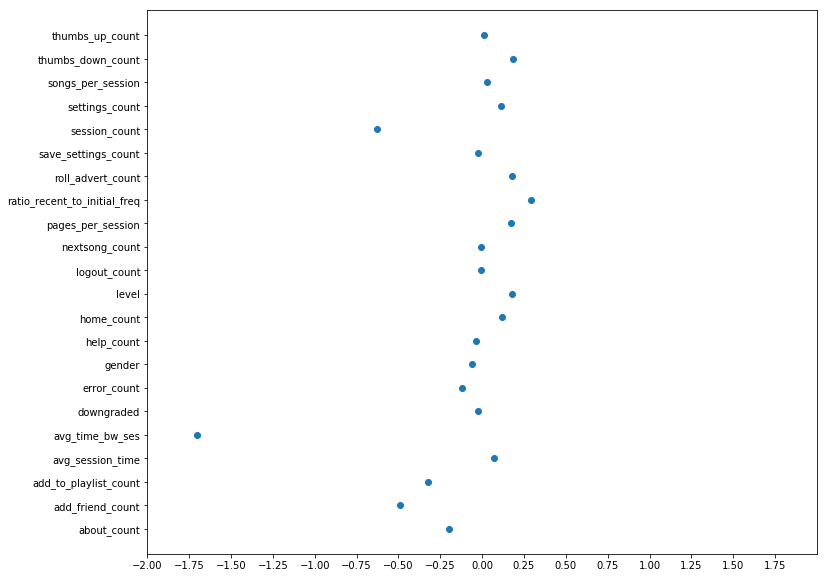

In [88]:
#Visualize features to their coefficients
y,x = zip(*sorted_features)
plt.figure(figsize=(12,10))
plt.axis(xmin=-2, xmax=2)
plt.xticks(np.arange(-2, 2, 0.25))
plt.scatter(x,y);

# Conclusion

## Models

We see that our best model in term's of our agreed upon metric F1 score is **Support Vector Classifier**. We have achieved 82% accuracy and 57% F1 score on the test data post hyperparameter tuning and cross validation.

We have tried to use the direct model without any hyperparameter tuning or cross validation for each of the models and then refined them using tuning of paramters and cross validation. We chose Cross Validation over TrainValidationSplit as we have a small dataset and Cross validation generally provides a better fit for Classification purposes.

Also note that we did explicitly call out best model for each of the models post validation, which is not necessary as the models choose best model for estimation purposes by default. The reason why I did it is only to save my best model before I close my session as the project spanned across multiple days.

Few interesting details I noticed about the models:
* I wonder if **Support Vector Classifier** will give us even better results if we increase our maxIter parameter. However, it is important to note that SVC is very time consuming and has taken significantly higher amount of time to train on this small dataset relatively when compared with the other models. The current best model has maxIter 200, and regParam 0.01. It has no intercept.
* **Logistic regression** got a better F1 score without any hyperparameter tuning. It has got an F1 score of 50% without any tuning whilst only getting 47% post tuning.
* **Random Forests**, without hyperparameter tuning got zero Precision and Recall (becuase of which I have to edit my evaluate_model function too to include exception handling for F1 score). Best model had 30 Trees and maxDepth 8. This is because of having zero true positives. The F1 score improved later to 26% upon refinement of the model using tuning and cross validation.
* **Gradient Boosting Trees** has remained at an F1 score of 19% with or without tuning implying that the default parameters have been the best for this dataset. The best model has maxDepth 5, maxIter 50, and stepSize 0.1

## Features
The dominant features remained consistent across models.
In our winning model SVC, the features playing an important role in deciding whether a user will Churn or not are 
* **Average time between sessions**. It is by far the most dominant feature. It is inversely correlated as expected. Users having more time in between sessions see less value in paying or using a platform which has a recurring monthly subscription. Even if he/she doesn't pay, they might feel the platform is not needed for them anymore.
* **Session Count**, **Add friend count**, and **Add to playlist count** also had a surprisingly negative effect which is contradicting our hypothesis.
* **Ratio recent count to initial count** for which we had to feature engineer the field with more difficulty than the others had positive effect as expected. However, the extent of it was less than what we expected.

Finally, 22 features is fine to work with our models given the relatively small dataset that we worked for our project. However I strongly believe we should use PCA for feature selection before proceeding with any of our models if we want to deploy it on any large datasets.